In [9]:
import pandas as pd
import datetime as dt

In [10]:
df = pd.read_csv(
)

In [11]:
df

,id,MemberId,Timestamp,ITEM_DESCRIPTION,total_qty,total_value,LocationId
0,22953781,226792,2023-01-13 11:04:31.070,PAYSAN UNSLTD BUTTER LEAF 200G,1,539.91,44
1,23583043,138127,2023-01-21 06:50:26.410,7D CRSNT JMBO HZLNUT&COCOA100G,1,7.00,32
2,24155969,953998,2023-01-27 19:25:46.123,ORINEX BKNG SHEET 15S(52X40CM),1,278.65,33
3,24160073,713967,2023-01-27 20:06:17.067,NIVEA MEN DEEP A/PRSPRANT 50ML,2,315.60,37
4,23693308,789682,2023-01-22 11:39:50.193,HIMALAYA CMPL CR T/PST 125G,1,127.95,13
...,...,...,...,...,...,...,...
3599995,31337860,725530,2023-04-06 14:16:51.040,INDOMI VEGETABLE FLAVOR 5X75GM,1,388.55,26
3599996,32899466,99364,2023-04-22 22:43:26.990,GREEN SLICE OLIVE,1,1313.29,38
3599997,32719302,257584,2023-04-20 15:32:54.893,SAMBUSA CHEDDAR CHEESE -PCS,10,62.72,40
3599998,33289649,88309,2023-04-28 10:44:15.200,ALYOUM PREM.CHKN WHL-LEGS 900G,1,955.16,43


In [15]:
df['Timestamp'].dtype

dtype('O')

In [26]:
df1 = df.copy()

In [27]:
df1.columns = df1.columns.str.lower()


In [28]:
df1['timestamp'] = pd.to_datetime(df1['timestamp'])


In [29]:
df1['timestamp'].dtype

dtype('<M8[ns]')

In [30]:
#This functions extracts first day of the invoice month
def get_month(x): 
    return dt.datetime(x.year, x.month, 1)

In [36]:
#applying the above function to get invoice month
df1['invoice_month'] = df1['timestamp'].apply(get_month)
#grouping the members into cohort month by first month of their transaction
df1['cohort_month']= df1.groupby('memberid')['invoice_month'].transform('min')

In [38]:
df1.head()

,id,memberid,timestamp,item_description,total_qty,total_value,locationid,invoice_month,cohort_month
0,22953781,226792,2023-01-13 11:04:31.070,PAYSAN UNSLTD BUTTER LEAF 200G,1,539.91,44,2023-01-01,2022-09-01
1,23583043,138127,2023-01-21 06:50:26.410,7D CRSNT JMBO HZLNUT&COCOA100G,1,7.00,32,2023-01-01,2022-09-01
2,24155969,953998,2023-01-27 19:25:46.123,ORINEX BKNG SHEET 15S(52X40CM),1,278.65,33,2023-01-01,2022-11-01
3,24160073,713967,2023-01-27 20:06:17.067,NIVEA MEN DEEP A/PRSPRANT 50ML,2,315.60,37,2023-01-01,2022-12-01
4,23693308,789682,2023-01-22 11:39:50.193,HIMALAYA CMPL CR T/PST 125G,1,127.95,13,2023-01-01,2022-09-01


In [39]:
# This function integer values of year, month and day
def get_date_int(df,column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

In [46]:
invoice_year, invoice_month, _ = get_date_int(df1, 'invoice_month')
cohort_year, cohort_month, _ = get_date_int(df1, 'cohort_month')
years_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month
#multiplying years_diff by 12 to convert it to months
#+1 is there so the cohort_index stars with 1 and not 0
df1['cohort_index'] = years_diff*12 + month_diff + 1

In [47]:
df1.head()

,id,memberid,timestamp,item_description,total_qty,total_value,locationid,invoice_month,cohort_month,cohort_index
0,22953781,226792,2023-01-13 11:04:31.070,PAYSAN UNSLTD BUTTER LEAF 200G,1,539.91,44,2023-01-01,2022-09-01,5
1,23583043,138127,2023-01-21 06:50:26.410,7D CRSNT JMBO HZLNUT&COCOA100G,1,7.00,32,2023-01-01,2022-09-01,5
2,24155969,953998,2023-01-27 19:25:46.123,ORINEX BKNG SHEET 15S(52X40CM),1,278.65,33,2023-01-01,2022-11-01,3
3,24160073,713967,2023-01-27 20:06:17.067,NIVEA MEN DEEP A/PRSPRANT 50ML,2,315.60,37,2023-01-01,2022-12-01,2
4,23693308,789682,2023-01-22 11:39:50.193,HIMALAYA CMPL CR T/PST 125G,1,127.95,13,2023-01-01,2022-09-01,5


In [127]:
cohort_data = df1.groupby(['cohort_month','cohort_index'])['memberid'].apply(pd.Series.nunique).reset_index()
cohort_counts = cohort_data.pivot(index='cohort_month',columns='cohort_index',values='memberid')

In [128]:
cohort_counts

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,
2022-09-01,212319.0,60489.0,57539.0,56864.0,55391.0,53708.0,51764.0,50883.0,52041.0,49436.0,46169.0,48027.0
2022-10-01,150805.0,31655.0,30778.0,29632.0,28564.0,28135.0,27165.0,27812.0,26742.0,25143.0,25856.0,NaN
2022-11-01,120672.0,20247.0,19224.0,18595.0,18155.0,17467.0,17566.0,17043.0,16618.0,16663.0,NaN,NaN
2022-12-01,103003.0,15221.0,14446.0,13841.0,13170.0,13551.0,13017.0,12348.0,12556.0,NaN,NaN,NaN
2023-01-01,89578.0,11890.0,11174.0,10448.0,10541.0,10153.0,9909.0,9984.0,NaN,NaN,NaN,NaN
2023-02-01,81070.0,9428.0,8900.0,8736.0,8655.0,8019.0,8190.0,NaN,NaN,NaN,NaN,NaN
2023-03-01,87908.0,8990.0,8000.0,7739.0,7491.0,7315.0,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-01,75433.0,7311.0,6977.0,6617.0,6390.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-01,67328.0,6917.0,6337.0,6043.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [200]:
# Create a DataFrame to store cohort data
cohort_data_new = df1.groupby(['cohort_month', 'cohort_index'])['memberid'].apply(list).reset_index()

# Define a function to calculate subsequent counts
def count_subset_members(row):
    cohort_month = row['cohort_month']
    cohort_index = row['cohort_index']
    mask = (cohort_data_new['cohort_month'] == cohort_month) & (cohort_data_new['cohort_index'] >= cohort_index)
    members = set(cohort_data_new.loc[mask, 'memberid'].explode())
    return len(members)

# Apply the function to calculate subsequent counts
cohort_data_new['subset_member_count'] = cohort_data_new.apply(count_subset_members, axis=1)

# Pivot the data to get the final cohort_counts table
cohort_counts_new = cohort_data_new.pivot(index='cohort_month', columns='cohort_index', values='subset_member_count')

In [202]:
cohort_counts_new

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,
2022-09-01,212319.0,151664.0,146225.0,140851.0,135067.0,128929.0,121998.0,113787.0,103768.0,90298.0,72486.0,48027.0
2022-10-01,150805.0,95666.0,91119.0,86513.0,81638.0,76244.0,69927.0,62819.0,53386.0,41381.0,25856.0,NaN
2022-11-01,120672.0,66931.0,62761.0,58754.0,54236.0,49031.0,43204.0,36296.0,27745.0,16663.0,NaN,NaN
2022-12-01,103003.0,51879.0,47872.0,43767.0,39281.0,34450.0,28450.0,21249.0,12556.0,NaN,NaN,NaN
2023-01-01,89578.0,39873.0,36041.0,32039.0,27802.0,22874.0,17083.0,9984.0,NaN,NaN,NaN,NaN
2023-02-01,81070.0,31442.0,27667.0,23771.0,19354.0,14139.0,8190.0,NaN,NaN,NaN,NaN,NaN
2023-03-01,87908.0,26647.0,22130.0,17840.0,13010.0,7315.0,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-01,75433.0,19955.0,15884.0,11420.0,6390.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-01,67328.0,15336.0,10842.0,6043.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


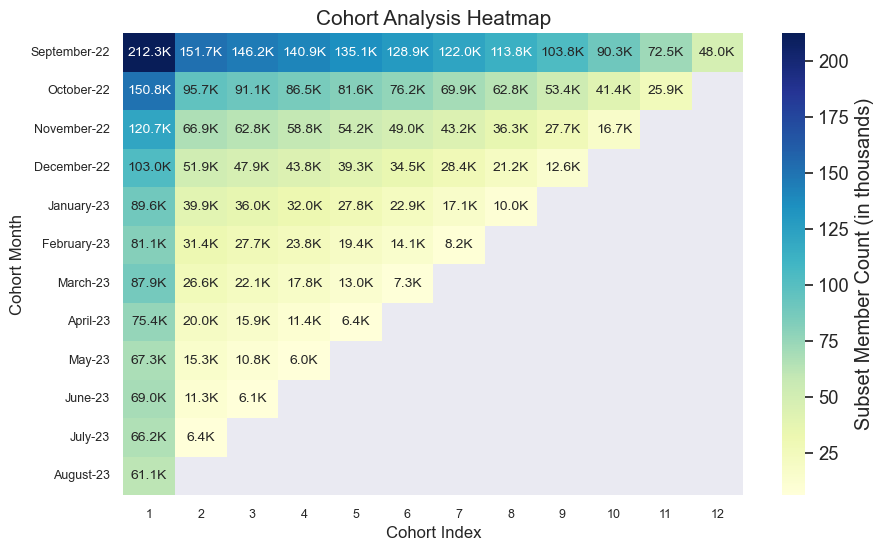

In [206]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create a heatmap
plt.figure(figsize=(10, 6))  # Set the figure size

# Create the heatmap using seaborn with custom annotation format
def format_annotations(value):
    if pd.notna(value):
        if value >= 1000:
            return f'{value / 1000:.1f}K'
        else:
            return str(int(value))
    else:
        return ''  # Return an empty string for NaN values

# Apply the format_annotations function to cohort_counts_new
formatted_cohort_counts = cohort_counts_new.applymap(format_annotations)

# Set the font size for annotations
font_size = 10  # You can adjust this value to your desired font size

# Create the heatmap
ax = sns.heatmap(
    cohort_counts_new / 1000,  # Divide the values by 1000 to display in thousands
    annot=formatted_cohort_counts,
    fmt='',  # Empty format string since we're providing custom annotations
    cmap='YlGnBu',
    cbar_kws={'label': 'Subset Member Count (in thousands)'},
    annot_kws={'size': font_size}  # Set the font size
)

# Format y-axis labels as "MMMM-YY"
custom_y_labels = [pd.to_datetime(date).strftime('%B-%y') for date in cohort_counts_new.index]

# Set custom y-axis labels and reduce their font size
ax.set_yticklabels(custom_y_labels, fontsize=font_size * 0.9)  # Reduce font size by 10%

# Reduce the font size of x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), fontsize=font_size * 0.9)  # Reduce font size by 10%

# Set axis labels and title
plt.xlabel('Cohort Index', fontsize=font_size * 1.2)  # Increase font size for x-axis label
plt.ylabel('Cohort Month', fontsize=font_size * 1.2)  # Increase font size for y-axis label
plt.title('Cohort Analysis Heatmap', fontsize=font_size * 1.5)  # Increase font size for title

# Show the heatmap
plt.show()


In [208]:
# Calculate the initial cohort size
initial_cohort_size = cohort_counts_new.iloc[:, 0]

# Calculate the count of retained customers for each cohort month
retained_percent = cohort_counts_new.divide(initial_cohort_size, axis=0)*100

# Print or use the retained_counts DataFrame
retained_percent

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,
2022-09-01,100.0,71.432137,68.870426,66.339329,63.615126,60.724193,57.459766,53.592472,48.873629,42.529402,34.140138,22.620208
2022-10-01,100.0,63.436889,60.421737,57.367461,54.134810,50.558005,46.369152,41.655781,35.400683,27.440072,17.145320,NaN
2022-11-01,100.0,55.465228,52.009580,48.689008,44.944975,40.631630,35.802837,30.078229,22.992078,13.808506,NaN,NaN
2022-12-01,100.0,50.366494,46.476316,42.490995,38.135782,33.445628,27.620555,20.629496,12.189936,NaN,NaN,NaN
2023-01-01,100.0,44.512045,40.234209,35.766594,31.036638,25.535288,19.070531,11.145594,NaN,NaN,NaN,NaN
2023-02-01,100.0,38.783767,34.127297,29.321574,23.873196,17.440484,10.102381,NaN,NaN,NaN,NaN,NaN
2023-03-01,100.0,30.312372,25.174046,20.293944,14.799563,8.321199,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-01,100.0,26.453939,21.057097,15.139263,8.471094,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-01,100.0,22.778042,16.103256,8.975463,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
